In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import sqlite3
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import fiona
from shapely.geometry import Point
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import libpysal as ps
import contextily as cx

# California Collision Data
## Using Machine Learning Models to Analyze Collision Data 


California Collision Data
Using Machine Learning Models to Analyze Collision Data 
California Highway Patrol maintains a public database, known as the Statewide Integrated Traffic Records System (SWITRS), that is used for collecting and processing data gathered from a collision scene. The collision data is collected by CHP and local police departments, however collision data from private roads are not obligated to be shared (e.g. UCPD jurisdiction for University of California). For this project, I'll be looking into answering a research question about the data through the use of a machine learning model.

## Motivation
Motivation for asking questions about collision data include: transit research, improving transit safety, and understanding how transportation might vary for communities. An example of a potential stakeholder for this data could be a California county municipality that oversees transportation. Since the collision data is maintained on a county level (and sometimes GPS data), further analysis could be done for gaining insight into a certain community. Enforcement agencies can also utilize collision data as a way of allocating resources for preventing injuries

## Dataset
To generate a report of collision data from the SWITRS database, users are limited to only selecting from a specific county at one time and also waiting in a queue for the report to be created. Because of this, I instead referred to a Kaggle page that contains a SQLite database file of collision data for all counties in CA from 2001 to 2020.

With the databse file, I then used a program called DB Browser in order visualize the tables. The database includes three primary tables:

* `collisions`: information of individual collision occurrences across CA
* `parties`: information about parties involved in a collision
* `victims`: information about injuries of specific people involved in a collision

I then exported a CSV of the table I wanted to work with for a specific year (2009). This project will only look at the `collisions` table.

The `collisions` table itself table has over 50 features that describe information about a certain collision such as what county it occurred in, the estimated population of the area where it happened, number of parties involved, etc. Each row represents the data for a specific collision in California.


In [2]:
collisions = pd.read_csv("crash_data_2009.csv", dtype=object)

In [3]:
collisions.head()

,case_id,jurisdiction,officer_id,reporting_district,chp_shift,population,county_city_location,county_location,special_condition,beat_type,...,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,primary_ramp,secondary_ramp,latitude,longitude,collision_date,collision_time,process_date
0,3858022,1005,P379,2C,not chp,>250000,1005,fresno,0,not chp,...,0,0,0,NaN,NaN,NaN,NaN,2009-02-03,17:11:00,2009-04-27
1,3899441,9120,17248,NaN,2200 thru 0559,2500 to 10000,0801,del norte,0,chp state highway,...,0,0,0,NaN,NaN,NaN,NaN,2009-02-28,01:45:00,2009-11-02
2,3899442,9530,19005,NaN,0600 thru 1359,>250000,1942,los angeles,0,chp state highway,...,0,0,0,NaN,NaN,33.86465,-118.28533,2009-02-09,10:20:00,2010-01-14
3,3899445,9530,19284,NaN,1400 thru 2159,>250000,1942,los angeles,0,chp state highway,...,0,0,0,NaN,NaN,33.7912,-118.2823,2009-02-18,15:50:00,2010-01-13
4,3899446,9530,19289,NaN,1400 thru 2159,25000 to 50000,1939,los angeles,0,chp state highway,...,0,0,0,NaN,NaN,33.8845,-118.3526,2009-02-11,17:35:00,2010-01-11


For example, the first row above describes a crash that occurred in Fresno county and it wasn't reported by a CHP officer.

Choosing to look at collisions solely on GPS data restricts the analysis of smaller counties that may not have enough reported entries. Del Norte county alone only has 3 collision entries available that have GPS data. Because GPS data for collisions aren’t fully available and sometimes unreliable, I instead chose to look at collisions at a county level.


The figure below shows collisions with GPS data mapped. As you can see, the coordinates of some entries end up being mapped onto the ocean or outside of California state boundaries.

In [4]:
coords = collisions.dropna(subset=["longitude", "latitude"]).reset_index(drop=True)

In [5]:
coords_gdf = gpd.GeoDataFrame(coords, geometry=gpd.points_from_xy(coords["longitude"], coords["latitude"]))
coords_gdf = coords_gdf.set_crs("EPSG:4326")

Text(0.5, 1.0, 'Map of California Collision GPS Data')

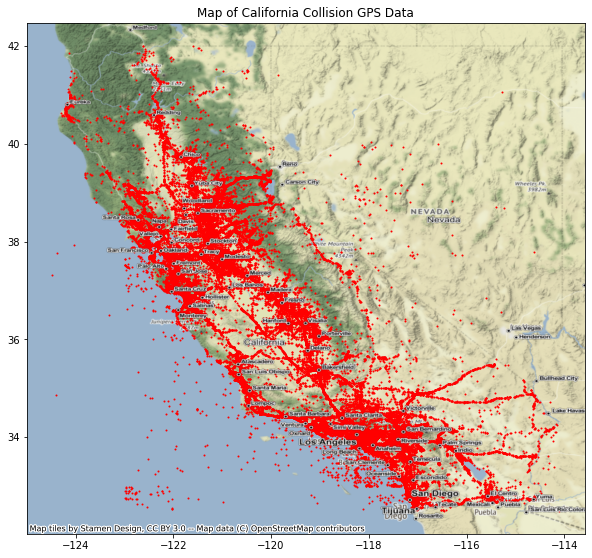

In [6]:
ax = coords_gdf.plot(figsize=(10, 10), markersize=1, color="red")
cx.add_basemap(ax=ax, crs=coords_gdf.crs.to_string(), source=cx.providers.Stamen.Terrain)
cx.add_basemap(ax=ax, crs=coords_gdf.crs.to_string(), source=cx.providers.Stamen.TonerLabels)
plt.title("Map of California Collision GPS Data")

## Preprocessing

Tasks for preprocessing the data include: 

* Adding new columns for time (`collision_month`, `collision_hour`), converting columns to appropriate data type
* Filtering out collisions that had NaN values for important features
* Add a new column severe_injuries where:
    * 1 : collision had severe injuries
    * 0 : collision did not have severe injuries

###### Adding month and hour column

In [7]:
def monthCol(df, col):
    """ 
    returns month value from the column of a dataframe
    """
    month = df[col].str.extract(r"^\d{4}\-0(\d)|^\d{4}\-(\d{2})", expand=False).values
    return pd.Series(month[month == month].astype(int))

def hourCol(df, col):
    """
    returns hour value from the column of a dataframe
    """
    hour = df[col].str.extract(r"(^[^0]\d)|^0(\d)", expand=False).values
    return pd.Series(hour[hour == hour]).astype(int)

collisions["collision_month"] = monthCol(collisions, "collision_date")
collisions["collision_hour"] = hourCol(collisions, "collision_time")

###### Preprocessing (converting numeric features into int)

In [8]:
numerical_features = ["party_count", "injured_victims", "killed_victims", "collision_hour", "collision_month"]

def convertToInt(df, numerical_features):
    """
    converts numerical_features 
    in df to type int
    """
    copy = df.copy()
    for f in numerical_features:
        if copy[f].dtype != "float64":
            copy[f] = collisions[f].astype(int)
    return copy
collisions = convertToInt(collisions, numerical_features)

###### Preprocessing (removing rows that have NaN for the given feature or null values for features not available across counties)

In [9]:
clean_list = ["county_location", "population", "weather_1", "road_surface", "collision_severity", 
              "lighting", "party_count", "injured_victims", "killed_victims", "collision_hour", 
              "collision_month", "type_of_collision", "hit_and_run", "pedestrian_action", 
              "pedestrian_collision", "pcf_violation_category", "motor_vehicle_involved_with"]

def removeNaN(df, clean_list):
    """
    removes NaN from given features in df; also removes rows that have certain value
    for a specific feature because of inconsistency among county collision data
    """
    copy = df.copy()
    copy = copy.dropna(subset=clean_list).reset_index(drop=True)
    copy = copy[~copy["pedestrian_action"].isin(["using school bus"])]
    copy = copy[~copy["pcf_violation_category"].isin(["brakes", "fell asleep", "lights"])]
    copy = copy[~copy["motor_vehicle_involved_with"].isin(["train"])]
    return copy
    
collisions = removeNaN(collisions, clean_list)

In [10]:
#function for one-hot encoding categorical features

def ohe_cols(data, ohe_list):
    """
    returns a dataframe with the given features 
    one hot encoded
    """
    ohe_dataframe = pd.DataFrame(index=np.arange(data.shape[0]))
    for col in ohe_list:
        enc = OneHotEncoder(handle_unknown='ignore')
        ohe_dataframe = ohe_dataframe.join(pd.DataFrame(enc.fit_transform(data[[col]]).toarray(), 
                                    columns = enc.get_feature_names_out()).set_index(data.index))
    return ohe_dataframe

## Research Question: Can a model classify whether a collision resulted in severe injuries?
#### Based on given information, can you predict whether a crash had severe injuries or not?

Collision data relies on reporting officer to note down all available information, but sometimes there may be instances where data collection isn’t accurate or reliable. This model could be used in cases where information about severe injuries in a collision aren't present. Knowing whether a collision resulted in severe injuries based on certain features, such as pedestrian involvement or type of collision, could be important for understanding which transit safety initiatives would work best in a region for preventing severe injuries. 

I will be creating a classification model to predict whether a model resulted in severe injuries, where:
* 1 : collision had severe injuries
* 0 : collision did not have severe injuries

based on the assumption that the information isn't already available. For the EDA and Feature Selection process of answering this question, I chose to only look at collisions in Contra Costa county because the choice of my classification model has a long training time for larger datasets. I will then use the trained model on other counties in the Bay Area and compare results.

To answer this question, we'll use the `injured_victims`, `killed_victims`, and `collision_severity` columns as information for knowing the "true" class of each crash, and
therefore won't use them in the training of our model. The purpose of this model is to see if one can classify a crash as "severe" given only certain information available (otherwise if the above information was available then classification wouldn't be needed).

###### Adding a new column to the `collisions` dataframe that states whether a collision had severe injuries or not

In [11]:
collisions["severe_injuries"] = (collisions["killed_victims"] + collisions["injured_victims"]).apply(lambda num: 1 if num > 0 else 0)

###### Creating a `contra_costa` dataframe

In [12]:
contra_costa = collisions[collisions["county_location"] == "contra costa"].reset_index(drop=True)
contra_costa.head(3)

,case_id,jurisdiction,officer_id,reporting_district,chp_shift,population,county_city_location,county_location,special_condition,beat_type,...,primary_ramp,secondary_ramp,latitude,longitude,collision_date,collision_time,process_date,collision_month,collision_hour,severe_injuries
0,3982945,713,K38,NaN,not chp,2500 to 10000,0713,contra costa,0,not chp,...,NaN,NaN,NaN,NaN,2009-01-12,15:26:00,2009-09-16,1,15.0,0
1,3989833,700,61366,57,not chp,10000 to 25000,0734,contra costa,0,not chp,...,NaN,NaN,NaN,NaN,2009-01-03,02:19:00,2009-09-09,1,15.0,0
2,3990654,700,52040,057,not chp,10000 to 25000,0734,contra costa,0,not chp,...,NaN,NaN,NaN,NaN,2009-01-07,14:25:00,2009-09-10,1,4.0,0


#### EDA

The graphs below show count plots for displaying the distribution of `severe_injuries` amongst categorical features, and also box plots of `crash_hour` and `crash_month` in relation to severe_injuries, which suggests that on average most collisions occurred in June and in the afternoon

Text(0.5, 1.0, 'Distribution of severe injuries along hours')

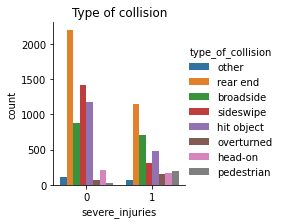

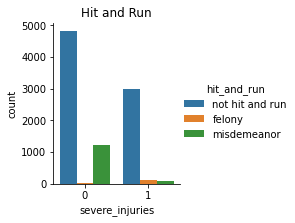

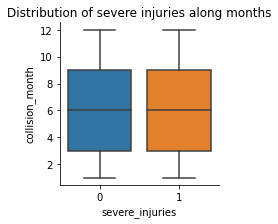

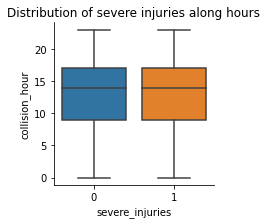

In [13]:
contra_costa_eda = contra_costa.copy();

sns.catplot(contra_costa_eda, x="severe_injuries", hue="type_of_collision", kind="count", height=3)
plt.title("Type of collision")
sns.catplot(contra_costa_eda, x="severe_injuries", hue="hit_and_run", kind="count", height=3)
plt.title("Hit and Run")
sns.catplot(contra_costa_eda, x="severe_injuries", y="collision_month", kind="box", height=3)
plt.title("Distribution of severe injuries along months")
sns.catplot(contra_costa_eda, x="severe_injuries", y="collision_hour", kind="box", height=3)
plt.title("Distribution of severe injuries along hours")

Based on the data and prior assumptions, information regarding pedestrians, vehicles involved, and the primary collision factor seemed to give more insight into knowing whether a collision resulted in severe injuries. This suggests that data collection about pedestrians and vehicles involved and primary collision factor could be important for understanding how severe a collision may be. Below are some of the different values that are used to describe a collision (PCF: primary collision factor).

In [14]:
contra_costa["pedestrian_action"].unique()

array(['no pedestrian involved', 'crossing in intersection crosswalk',
       'in road', 'crossing not in crosswalk', 'not in road',
       'crossing non-intersection crosswalk'], dtype=object)

In [15]:
contra_costa["motor_vehicle_involved_with"].unique()

array(['other object', 'parked motor vehicle', 'other motor vehicle',
       'fixed object', 'bicycle', 'motor vehicle on other roadway',
       'pedestrian', 'non-collision', 'animal'], dtype=object)

In [16]:
contra_costa["pcf_violation_category"].unique()

array(['speeding', 'dui', 'other than driver (or pedestrian)',
       'improper passing', 'automobile right of way',
       'other hazardous violation', 'unknown', 'improper turning',
       'unsafe lane change', 'other equipment', 'wrong side of road',
       'traffic signals and signs', 'unsafe starting or backing',
       'following too closely', 'pedestrian right of way',
       'pedestrian violation', 'hazardous parking',
       'other improper driving', 'impeding traffic'], dtype=object)

Along with the plots, I used a correlation matrix to help determine which categorical features seem to have a high correlation with whether a crash had severe injuries or not

In [17]:
contra_costa_ohe = ohe_cols(contra_costa, clean_list)
contra_costa_ohe["severe_injuries"] = contra_costa["severe_injuries"]
contra_costa_ohe.corr().loc[["severe_injuries"], :]

,county_location_contra costa,population_10000 to 25000,population_100000 to 250000,population_2500 to 10000,population_25000 to 50000,population_50000 to 100000,population_unincorporated,weather_1_clear,weather_1_cloudy,weather_1_fog,...,motor_vehicle_involved_with_animal,motor_vehicle_involved_with_bicycle,motor_vehicle_involved_with_fixed object,motor_vehicle_involved_with_motor vehicle on other roadway,motor_vehicle_involved_with_non-collision,motor_vehicle_involved_with_other motor vehicle,motor_vehicle_involved_with_other object,motor_vehicle_involved_with_parked motor vehicle,motor_vehicle_involved_with_pedestrian,severe_injuries
severe_injuries,NaN,-0.04153,0.090031,-0.018306,0.00695,-0.024623,-0.011279,0.029918,-0.026326,0.011032,...,-0.017158,0.161529,-0.028132,0.002845,0.091122,-0.016329,-0.050754,-0.138172,0.188652,1.0


Below is our the final list of features that will be incorporated in a feature matrix to be used by a classification model. I also define a function to create this feature matrix more easily.

In [18]:
# ohe_list is the list of columns we want one-hot encoded
ohe_list = ["type_of_collision", "hit_and_run", "pedestrian_action", "pedestrian_collision", "pcf_violation_category", "motor_vehicle_involved_with"]

# features is the list of non-one-hot encoded features
features = ["party_count", "collision_hour", "collision_month"]

###### Functions for creating feature dataframe

In [19]:
# complete list of features being used for creating feature dataframe
model_feature_list = ohe_list + features

def get_feature(df, feature):
    """
    returns given feature from df as a series
    """
    return df[feature]

def create_feature_df(df, ohe_list, features):
    """
    creates a feature dataframe of df according to
    the ohe_list and features list (above)
    """
    copy = df.copy().reset_index(drop=True)
    feature_df = ohe_cols(copy, ohe_list)#.reset_index(drop=True)
    for f in features:
        feature_df = feature_df.join(get_feature(df, f))
    return feature_df

In [20]:
create_feature_df(contra_costa, ohe_list, features).head(3)

,type_of_collision_broadside,type_of_collision_head-on,type_of_collision_hit object,type_of_collision_other,type_of_collision_overturned,type_of_collision_pedestrian,type_of_collision_rear end,type_of_collision_sideswipe,hit_and_run_felony,hit_and_run_misdemeanor,...,motor_vehicle_involved_with_fixed object,motor_vehicle_involved_with_motor vehicle on other roadway,motor_vehicle_involved_with_non-collision,motor_vehicle_involved_with_other motor vehicle,motor_vehicle_involved_with_other object,motor_vehicle_involved_with_parked motor vehicle,motor_vehicle_involved_with_pedestrian,party_count,collision_hour,collision_month
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,15.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,15.0,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,4.0,1


I then separate the `collisions` dataframe into a training and testing set.

* Training Set: Collection of data that our classificaiton model will be trained on
* Test Set: Collection of unseen data that we make classifications on and observe the results.

In [21]:
X = create_feature_df(contra_costa.drop(columns=["severe_injuries"]).reset_index(drop=True), ohe_list, features)
y = contra_costa["severe_injuries"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Classification Model: Support Vector Machine

I'll be using a Support Vector Machine (SVM) to classify whether a collision occurence resulted in severe injuries or not. A SVM attempts to separate points in a n-dimensional space by a hyperplane for classification problems. The goal of this model is to find a hyperplane with greatest margin between itself and all points to have a generalizable model. SVMs are good for smaller datasets, but not so good for larger datasets because of the increased training time with a greater number of features.

In [22]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [23]:
accuracy_score(y_train, svc.predict(X_train))

0.6837961637560835

In [24]:
accuracy_score(y_test, svc.predict(X_test))

0.6831258050665522

#### Hyperparameter Tuning using Grid Search Cross Validation

In order to increase the test set accuracy, I'll be using Grid Search Cross Validation to find hyperparameters that yield the highest accuracy. GridSearchCV uses cross validation, a form resampling for model validation. to find the model yielding best scoring for a metric based on given parameters. 

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
parameters_svc = {
    "C": [0.001, 0.01, 0.1, 1],
    "kernel": ["linear", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
    "class_weight": [None, "balanced"]
}
gridsearch_svc = GridSearchCV(SVC(), parameters_svc,
                          scoring=["accuracy"], cv=5, refit="accuracy")
gridsearch_svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1],
                         'class_weight': [None, 'balanced'],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             refit='accuracy', scoring=['accuracy'])

In [27]:
gridsearch_svc.best_params_

{'C': 0.1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}

In [28]:
svc_best = SVC(C=0.1, gamma="scale", kernel="linear")
svc_best.fit(X_train, y_train)

SVC(C=0.1, kernel='linear')

In [29]:
accuracy_score(y_train, svc_best.predict(X_train))

0.7102776982536502

In [30]:
accuracy_score(y_test, svc_best.predict(X_test))

0.7028767711464148

Using GridSearchCV, I was able to increase the test set accuracy from 0.68 to 0.70.

#### Classification Model Results for Bay Area Counties

Now that I have a classification model trained on a specific county, I want to try and use the same model on other counties in the Bay Area and compare the results. The workflow for this task is as follows:
1.  Create a dataframe for each county
2.  Split the dataframe into a training and test set
3.  Use the model trained on Contra Costa county data with hyperparameters chosen through GridSearchCV to make classifications on the test set of each county
4.  Repeat for each county

In [31]:
bay_area_counties_list = ["alameda", "contra costa", "marin", "napa", "san francisco", "san mateo", "santa clara", "solano", "sonoma"]

In [32]:
county_results = dict()

svc_county = SVC(C=0.1, gamma="scale", kernel="linear")
svc_county.fit(X_train, y_train)

for county in bay_area_counties_list:
    county_df = collisions[collisions["county_location"] == county].reset_index(drop=True)
    X_county = create_feature_df(county_df.drop(columns=["severe_injuries"]).reset_index(drop=True), ohe_list, features)
    y_county = county_df["severe_injuries"]
    X_train_county, X_test_county, y_train_county, y_test_county = train_test_split(X_county, y_county, test_size=0.25, random_state=42)
    county_results[county] = accuracy_score(y_test_county, svc_county.predict(X_test_county))

county_results

{'alameda': 0.7506636716356954,
 'contra costa': 0.7028767711464148,
 'marin': 0.711764705882353,
 'napa': 0.6214833759590793,
 'san francisco': 0.6512261580381471,
 'san mateo': 0.734282325029656,
 'santa clara': 0.6635220125786163,
 'solano': 0.6818181818181818,
 'sonoma': 0.6549019607843137}

In [33]:
bay_area_counties = gpd.read_file("Bay_Area_Counties")
bay_area_counties.head(3)

,county,fipsstco,objectid,geometry
0,Alameda,06001,1.0,"MULTIPOLYGON (((-122.21496 37.76113, -122.2156..."
1,Contra Costa,06013,2.0,"MULTIPOLYGON (((-121.95091 38.05392, -121.9505..."
2,Marin,06041,3.0,"MULTIPOLYGON (((-122.86959 38.02140, -122.8711..."


In [34]:
data = {"county_location": list(county_results.keys()), "model_accuracy": list(county_results.values())}
county_results_df = pd.DataFrame(data=data).set_index(bay_area_counties.index.values)
results = county_results_df["model_accuracy"].values
bay_area_counties["model_accuracy"] = results
bay_area_counties.head(3)

,county,fipsstco,objectid,geometry,model_accuracy
0,Alameda,06001,1.0,"MULTIPOLYGON (((-122.21496 37.76113, -122.2156...",0.750664
1,Contra Costa,06013,2.0,"MULTIPOLYGON (((-121.95091 38.05392, -121.9505...",0.702877
2,Marin,06041,3.0,"MULTIPOLYGON (((-122.86959 38.02140, -122.8711...",0.711765


In [35]:
# this cell is to include a coordinates column to make it easier for labelling each county
bay_area_counties['coords'] = bay_area_counties['geometry'].apply(lambda x: x.representative_point().coords[:])
bay_area_counties['coords'] = [coords[0] for coords in bay_area_counties['coords']]

In [36]:
bay_area_counties.head(3)

,county,fipsstco,objectid,geometry,model_accuracy,coords
0,Alameda,06001,1.0,"MULTIPOLYGON (((-122.21496 37.76113, -122.2156...",0.750664,"(-121.8640918791015, 37.67898099734099)"
1,Contra Costa,06013,2.0,"MULTIPOLYGON (((-121.95091 38.05392, -121.9505...",0.702877,"(-121.94869373248835, 37.90925899910327)"
2,Marin,06041,3.0,"MULTIPOLYGON (((-122.86959 38.02140, -122.8711...",0.711765,"(-122.70187870295834, 38.06801199895045)"


The figure below shows a map of how the model performs across other counties in the Bay Area. The map uses a sequential colour scheme to display counties that had a lower test set accuracy with a lighter tone, and a darker tone for counties with higher test set accuracy. From the map, we can see that the model performed better for Marin, Alameda, and San Mateo county, but not as well for Contra Costa and other counties. This may suggest that the three counties mentioned previously share similar transit data as Contra Costa, since the EDA and Feature Selection process was done using only Contra Costa data.

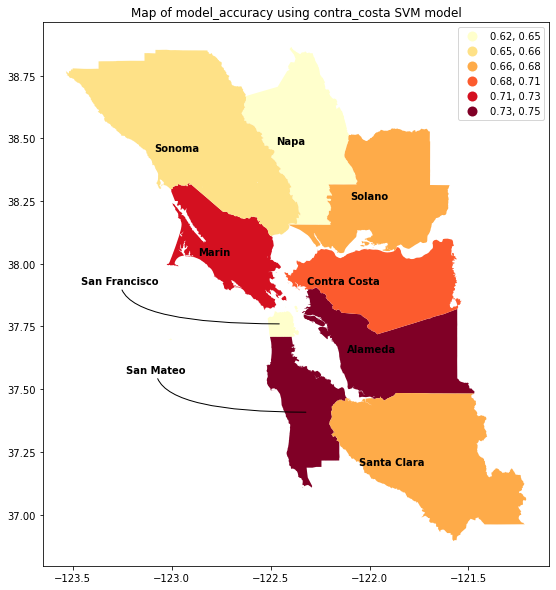

In [37]:
ax = bay_area_counties.plot(column="model_accuracy", figsize=(10,10), legend=True, cmap="YlOrRd", scheme="quantiles", k=6)
plt.title(f"Map of model_accuracy using contra_costa SVM model")
for index, row in bay_area_counties.iterrows():
    if row["county"] in ["San Francisco", "San Mateo"]:
        plt.annotate(text=row['county'], xy=row["coords"], xytext=row["coords"], horizontalalignment='right', verticalalignment='bottom', 
                     weight='bold', arrowprops=dict(arrowstyle="-",
                            connectionstyle="angle3"), textcoords='offset points')
    elif row["county"] in ["Contra Costa", "Santa Clara"]:
        plt.annotate(text=row['county'], xy=row["coords"], horizontalalignment='right', verticalalignment='bottom', weight='bold')
    else:
        plt.annotate(text=row['county'], xy=row["coords"], horizontalalignment='right', verticalalignment='top', weight='bold')
plt.savefig("bay_area_counties_results_cc_model.png", bbox_inches='tight')

While a model trained on one county could possibly be used for collision data from another, how different are the results from training a model given each county's data? The workflow for this task is similar to the last, except instead of using the SVM model trained on the `contra_costa` dataframe we instead utilize the training set of each county's dataframe. For the sake of space I already ran the models previously and below will compare the mapped results of each method:

Utilizing one SVM model             |  Utilizing multiple SVM models
:-------------------------:|:-------------------------:
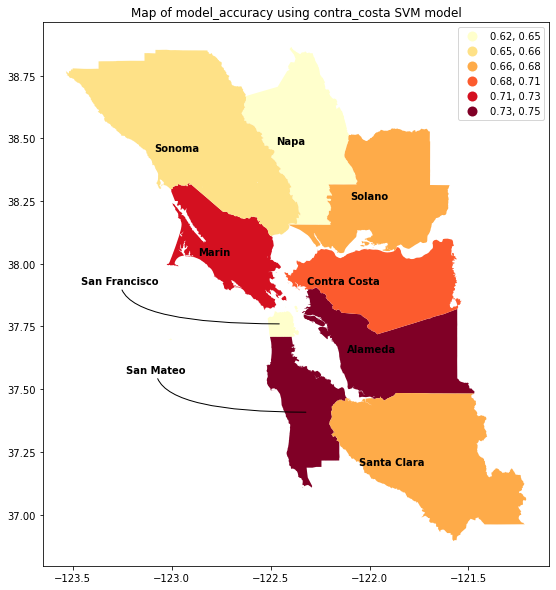  |  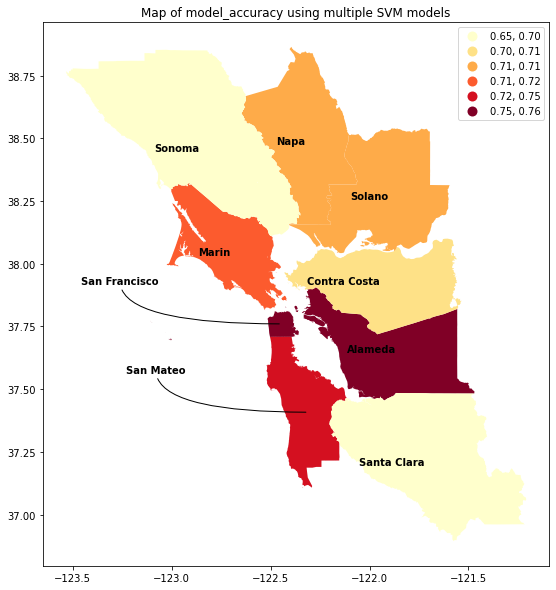


As you can see, some counties like San Francisco saw an increase in model accuracy when using a model trained on its own data for the classification of a collision resulting in severe injuries. The range of accuracy scores were greater when trying to use a model trained on Contra Costa data for other counties. Between the two maps, its seems like counties with higher populations performed better in their classification. However, it's also important to note that while a model was trained for each different county, the EDA and Feature Selection process was based solely on Contra Costa data, which may differ from data in other counties. For example, even though Santa Clara county had almost 5000 more collision entries, it performed worse when using a model trained on Santa Clara data. From the results, one key takeaway to acknowledge is how variable collision data can be across counties.

## Limitations and Conclusions

A significant portion of collision data have missing values, and while proper data collection could lead to less missing information and better performing models, this relies on CHP and local police departments across California which may be difficult to encourage. Additionally, results from a machine learning model may be dependent on the geographical location of where you’re making predictions/classifications. Collision data across counties can differ greatly, leading to the idea of looking at collisions at a city level instead of county level. For example, a model trained on Oakland may perform well on San Jose collision data given that both are metropolitan cities and might share similar transit data.

Overall, carefully analyzing collision data can be useful for improving the transit safety needs of a community. Understanding vulnerabilities regarding certain aspects of collisions can help an enforcement agency in concerting their safety efforts for preventing severe injuries, such as looking into specific pedestrian and collision factors. It's important to note that collision data isn’t the only information that can be used in models for transit research. Looking into data about individual communities (access to public transportation) and data on collision victims (demographics most affected in collisions, specific injuries, etc.) could also serve to offer insight.